# Modeling

In [1]:
!pwd

/home/jovyan/work/cold_start_models


In [4]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split


def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):
    
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))  / MULTIPLIER
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [5]:
with open('/home/jovyan/work/cold_start_models/dataset_3.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [6]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9481 entries, 0 to 9480
Data columns (total 39 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   age_access_type                                    9481 non-null   float64
 1   average_rating                                     9481 non-null   float64
 2   duration                                           9481 non-null   float64
 3   type                                               9481 non-null   object 
 4   name                                               9481 non-null   object 
 5   release_year                                       9481 non-null   object 
 6   target                                             9481 non-null   float64
 7   subscription_only                                  9481 non-null   object 
 8   uid                                                9481 non-null   object 
 9   top10gen

In [7]:
df_pr.columns

Index(['age_access_type', 'average_rating', 'duration', 'type', 'name',
       'release_year', 'target', 'subscription_only', 'uid',
       'top10genre_Drama', 'top10genre_Comedy', 'top10genre_Thriller',
       'top10genre_Action', 'top10genre_Melodrama', 'top10genre_Adventure',
       'top10genre_287a1485-7a88-4c2f-bc94-ca418b6c47a1',
       'top10genre_364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'top10genre_Family',
       'top10genre_Sci-Fi', 'top10actor_d08bba89-e937-40f3-b2a7-7ea26de4c246',
       'top10actor_fd401c6b-3e00-4f7f-aea7-5512df6b91e0',
       'top10actor_5463b4bc-e332-415c-aca8-11c0f217a9eb',
       'top10actor_5f3f6dc9-15fd-464f-91bc-b98c1e467f04',
       'top10actor_bebdaaad-69e1-49c4-ab58-89fc9acafaad',
       'top10actor_9703b641-2566-4e58-aebb-8d140805c0f3',
       'top10actor_fbdae856-85b9-4d4a-96dd-cc383571a488',
       'top10actor_dfd861c4-d2de-4bb6-bc6e-bae3f92a18a9',
       'top10actor_488a47a6-b3e1-40b3-acca-9f605202a040',
       'top10actor_3e94064c-14ef-4f11-9a

# 4

In [8]:
cat_features = ['type',
               'release_year', 'subscription_only',
               'top10genre_Drama', 'top10genre_Comedy', 'top10genre_Thriller',
               'top10genre_Action', 'top10genre_Melodrama', 'top10genre_Adventure',
               'top10genre_287a1485-7a88-4c2f-bc94-ca418b6c47a1',
               'top10genre_364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'top10genre_Family',
               'top10genre_Sci-Fi', 'top10actor_d08bba89-e937-40f3-b2a7-7ea26de4c246',
               'top10actor_fd401c6b-3e00-4f7f-aea7-5512df6b91e0',
               'top10actor_5463b4bc-e332-415c-aca8-11c0f217a9eb',
               'top10actor_5f3f6dc9-15fd-464f-91bc-b98c1e467f04',
               'top10actor_bebdaaad-69e1-49c4-ab58-89fc9acafaad',
               'top10actor_9703b641-2566-4e58-aebb-8d140805c0f3',
               'top10actor_fbdae856-85b9-4d4a-96dd-cc383571a488',
               'top10actor_dfd861c4-d2de-4bb6-bc6e-bae3f92a18a9',
               'top10actor_488a47a6-b3e1-40b3-acca-9f605202a040',
               'top10actor_3e94064c-14ef-4f11-9ada-50db5b806557',
               'top3director_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top3director_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top3director_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c',
               'top5country_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top5country_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top5country_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c', 'RENT', 'DTO',
               'SUBSCRIPTION', 'AVOD']

num_features = ['age_access_type', 'average_rating', 'duration']

target_transformer = TargetTransformer()

In [9]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9481 entries, 0 to 9480
Data columns (total 39 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   age_access_type                                    9481 non-null   float64
 1   average_rating                                     9481 non-null   float64
 2   duration                                           9481 non-null   float64
 3   type                                               9481 non-null   object 
 4   name                                               9481 non-null   object 
 5   release_year                                       9481 non-null   object 
 6   target                                             9481 non-null   float64
 7   subscription_only                                  9481 non-null   object 
 8   uid                                                9481 non-null   object 
 9   top10gen

In [10]:
MULTIPLIER = 100
X, y = df_pr.drop(['target', 'name', 'uid'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [13]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017501
0:	learn: 0.0426332	test: 0.0457567	best: 0.0457567 (0)	total: 53.3ms	remaining: 8m 53s
100:	learn: 0.0337007	test: 0.0404289	best: 0.0404289 (100)	total: 465ms	remaining: 45.6s
200:	learn: 0.0314651	test: 0.0391529	best: 0.0391529 (200)	total: 903ms	remaining: 44s
300:	learn: 0.0306315	test: 0.0386509	best: 0.0386504 (299)	total: 1.35s	remaining: 43.7s
400:	learn: 0.0301429	test: 0.0383965	best: 0.0383721 (371)	total: 1.79s	remaining: 43s
500:	learn: 0.0296388	test: 0.0381309	best: 0.0381309 (500)	total: 2.23s	remaining: 42.4s
600:	learn: 0.0291525	test: 0.0379596	best: 0.0379596 (600)	total: 2.69s	remaining: 42.2s
700:	learn: 0.0287148	test: 0.0378721	best: 0.0378593 (680)	total: 3.17s	remaining: 42.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03785620899
bestIteration = 714

Shrink model to first 715 iterations.


In [14]:
cat_model.save_model('4')

In [15]:
y_pred = cat_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [16]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   0.014993819497714138
RMSE:  0.12244925274461309
R2:    0.29545218713858545
MAE:   0.0389296639168611
MedAE: 0.0111136077930762
Adj_R2:  0.2927664902661785
------------------------------


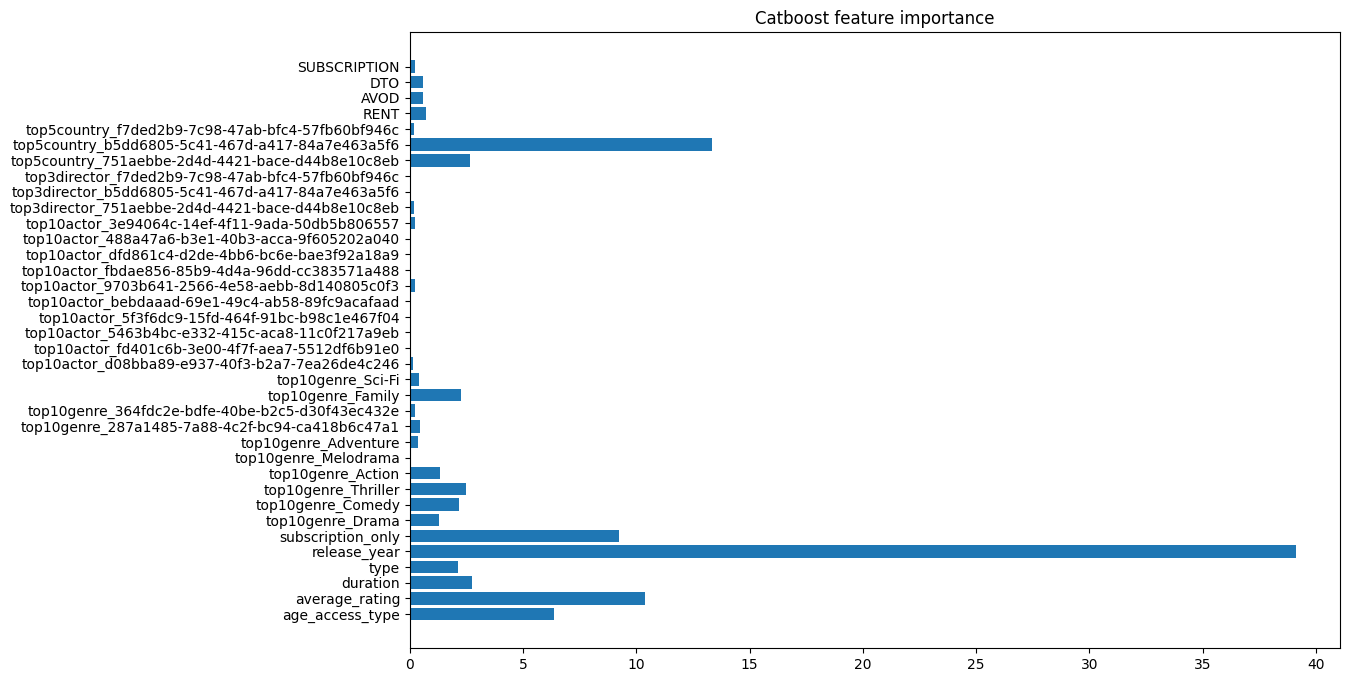

In [19]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

/tmp/ipykernel_38661/867147890.py:72: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)
/tmp/ipykernel_38661/867147890.py:73: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred)


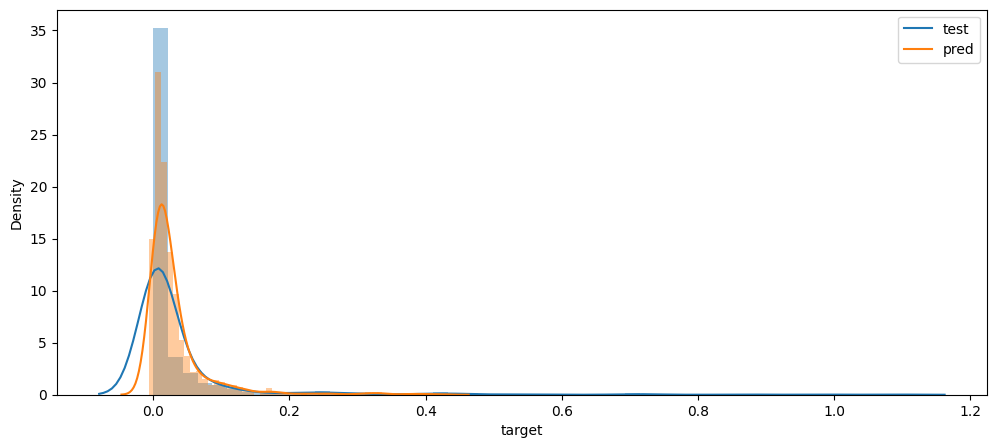

In [20]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

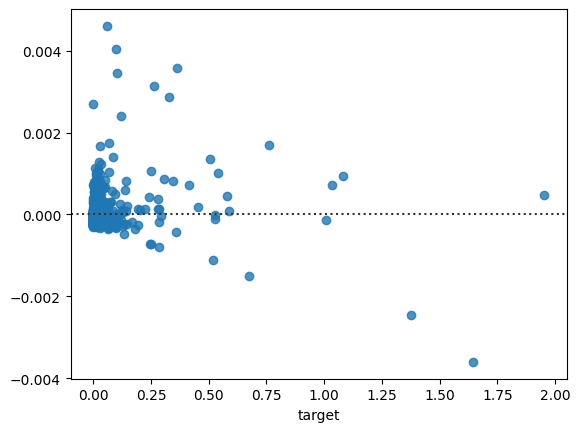

In [21]:
draw_residuals(y_test, y_pred, save_fig=False)

In [22]:
len(y_pred[y_pred <= 0])

41

# 4_1 no release_year

In [23]:
cat_features = ['type', 'subscription_only',
               'top10genre_Drama', 'top10genre_Comedy', 'top10genre_Thriller',
               'top10genre_Action', 'top10genre_Melodrama', 'top10genre_Adventure',
               'top10genre_287a1485-7a88-4c2f-bc94-ca418b6c47a1',
               'top10genre_364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'top10genre_Family',
               'top10genre_Sci-Fi', 'top10actor_d08bba89-e937-40f3-b2a7-7ea26de4c246',
               'top10actor_fd401c6b-3e00-4f7f-aea7-5512df6b91e0',
               'top10actor_5463b4bc-e332-415c-aca8-11c0f217a9eb',
               'top10actor_5f3f6dc9-15fd-464f-91bc-b98c1e467f04',
               'top10actor_bebdaaad-69e1-49c4-ab58-89fc9acafaad',
               'top10actor_9703b641-2566-4e58-aebb-8d140805c0f3',
               'top10actor_fbdae856-85b9-4d4a-96dd-cc383571a488',
               'top10actor_dfd861c4-d2de-4bb6-bc6e-bae3f92a18a9',
               'top10actor_488a47a6-b3e1-40b3-acca-9f605202a040',
               'top10actor_3e94064c-14ef-4f11-9ada-50db5b806557',
               'top3director_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top3director_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top3director_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c',
               'top5country_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top5country_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top5country_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c', 'RENT', 'DTO',
               'SUBSCRIPTION', 'AVOD']

num_features = ['age_access_type', 'average_rating', 'duration']

In [24]:
MULTIPLIER = 100
X, y = df_pr.drop(['target', 'name', 'release_year', 'uid'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [26]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017501
0:	learn: 0.0427725	test: 0.0458767	best: 0.0458767 (0)	total: 5.58ms	remaining: 55.7s
100:	learn: 0.0395413	test: 0.0427405	best: 0.0427405 (100)	total: 419ms	remaining: 41.1s
200:	learn: 0.0386742	test: 0.0419162	best: 0.0419150 (199)	total: 816ms	remaining: 39.8s
300:	learn: 0.0381768	test: 0.0416299	best: 0.0416299 (300)	total: 1.2s	remaining: 38.7s
400:	learn: 0.0378278	test: 0.0415906	best: 0.0415830 (396)	total: 1.61s	remaining: 38.5s
500:	learn: 0.0374547	test: 0.0415372	best: 0.0415198 (496)	total: 2s	remaining: 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.041489479
bestIteration = 539

Shrink model to first 540 iterations.


In [27]:
cat_model.save_model('4_1')

In [28]:
y_pred = cat_model.predict(X_test)

In [29]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   0.01904037423330461
RMSE:  0.1379868625388106
R2:    0.10530775535995096
MAE:   0.047110348255088384
MedAE: 0.022548249517475822
Adj_R2:  0.10199232618447174
------------------------------


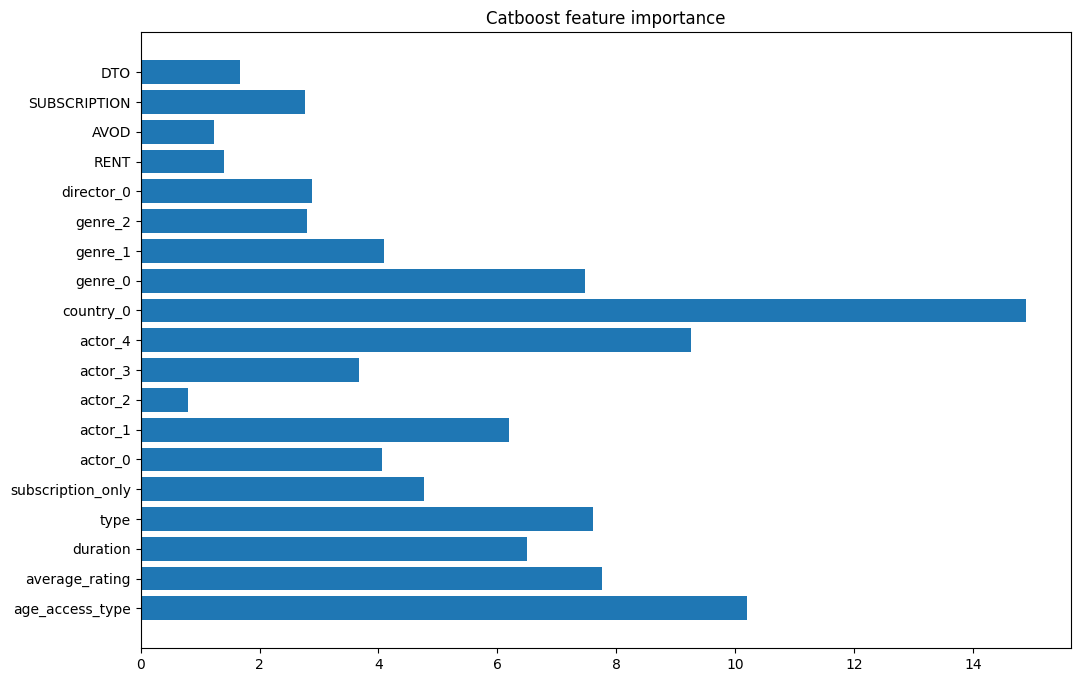

In [26]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

/tmp/ipykernel_1288/2698331858.py:68: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)
/tmp/ipykernel_1288/2698331858.py:69: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred)


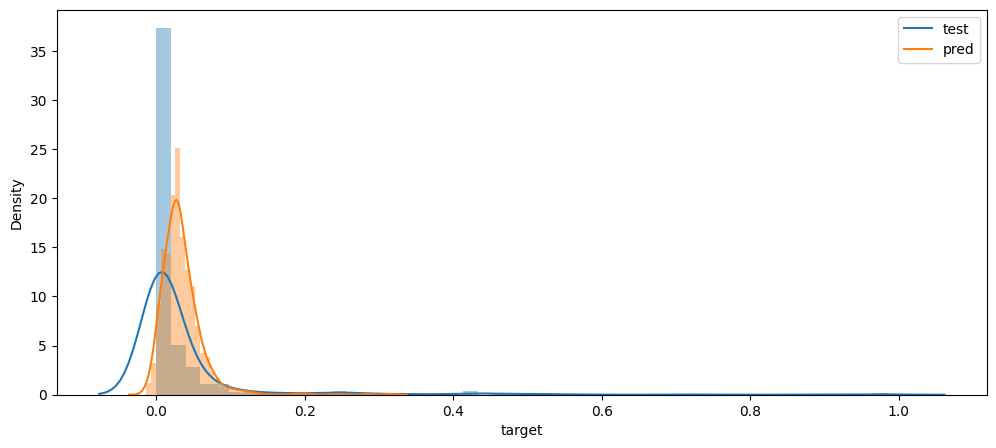

In [27]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

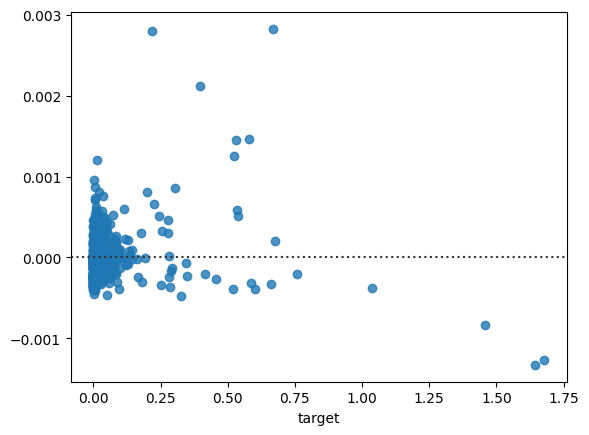

In [28]:
draw_residuals(y_test, y_pred, save_fig=False)

In [29]:
len(y_pred[y_pred <= 0])

24